## descriptive data exploration
* study the trending of correlation

### feature ranking
* correlation btw each feature and unit price
* random forest ranking


In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views(materialize=True)

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [3]:
# load data from virtual view
#df_transaction = ds.get_view_df('property_address_transactions')
# load from materialized view
df_transaction = ds.get_view_df('property_transaction_valid')
df_property = ds.get_view_df('property_addresses')
pp = Preprocess(df_transaction, df_property)

### retrieve the dataset

In [4]:
df_all_valid = pp.dataset(valid=True)
print('all dataset', df_all_valid.shape)
# last year transactions of valid properties
df_last_year_valid = pp.dataset(valid=True, date=('2016-10-01', '2017-10-01'))
print('last year', df_last_year_valid.shape)

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


all dataset (1369868, 24)


[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


last year (34192, 24)


### correlation between features and target(sqft_price)
* with geography: street, zip, city
* with property characteristic: sqft, lot_size_sqft

In [6]:
df_all_valid[:3]

,sqft,zip,year_built,eval_land,num_bath,sqft_price,lon,view,sold_price_zip_avg,sale_count_zip,...,sold_year,usable_sqft,sqft_zip_avg,sold_price,date,street,num_bed,impr_over_land,sqft_price_zip_avg,lat
0,1120,91911,1955.0,133145,1,399,-117.05661,0,228727.329169,23854,...,2017,7700.0,1493.117884,447000,2017-10-24,HILLTOP,3,0.833332,156.568207,32.61670
1,1204,91911,1959.0,126061,2,423,-117.06433,0,228727.329169,23854,...,2017,7900.0,1493.117884,510000,2017-09-27,EMERSON,3,2.734137,156.568207,32.61301
2,1050,91911,1956.0,270000,2,314,-117.05195,1,228727.329169,23854,...,2017,5200.0,1493.117884,330000,2017-09-27,JAMUL,3,0.222222,156.568207,32.62011


In [7]:
features = set(pp.get_feature_list('all')) - set(['date', 'street', 'zip', 'sold_year', 'sqft_price']) # exclude features not suitable
#features -= set(['year_built'])   # features under work

In [8]:
df_last_year_valid.columns

Index(['sqft', 'zip', 'year_built', 'eval_land', 'num_bath', 'sqft_price',
       'lon', 'view', 'sold_price_zip_avg', 'sale_count_zip', 'pool',
       'eval_imps', 'prop_count_zip', 'sold_age', 'sold_year', 'usable_sqft',
       'sqft_zip_avg', 'sold_price', 'date', 'street', 'num_bed',
       'impr_over_land', 'sqft_price_zip_avg', 'lat'],
      dtype='object')

In [9]:
df_transaction[:20][['str_no', 'street', 'st_type', 'city', 'zip', 'sold_price', 'sqft', 'usable_sqft', 'acre']]

,str_no,street,st_type,city,zip,sold_price,sqft,usable_sqft,acre
0,1113,HILLTOP,DR,CHULA VISTA,91911,447000,1120,7700.0,0
1,3305,GENOA,WAY,OCEANSIDE,92056,397000,1016,NaN,0
2,12038,CALLE DE LEON,None,EL CAJON,92019,335000,1220,0.0,0
3,190,BAUTISTA,CT,OCEANSIDE,92057,365000,1420,NaN,0
4,6725,LOPEZ GLEN,WAY,SAN DIEGO,92126,830000,2229,3300.0,0
5,422,MACHADO,WAY,VISTA,92083,870000,3580,9843.0,0
6,7605,PIPIT,PL,SAN DIEGO,92129,724000,2402,10000.0,0
7,3828,MONSERATE,TER,FALLBROOK,92028,665000,2556,NaN,127
8,17945,CAMINITO PINERO,None,SAN DIEGO,92128,295000,817,0.0,0
9,1350,SHOSHONE FALLS,DR,RAMONA,92065,348500,1044,NaN,0


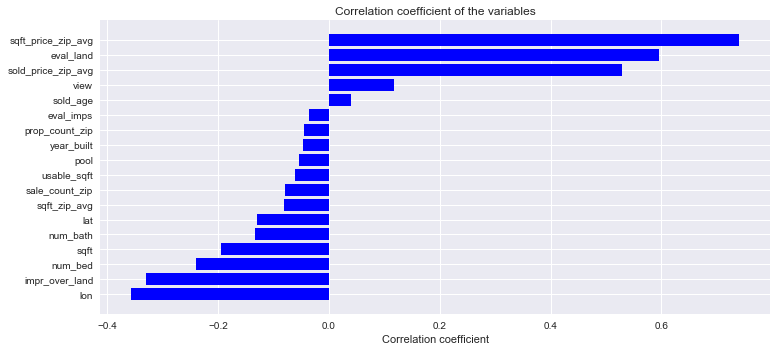

{'eval_imps': -0.036241948929103089,
 'eval_land': 0.59604917978065231,
 'impr_over_land': -0.32955327825307884,
 'lat': -0.12946973895837965,
 'lon': -0.35768887178044634,
 'num_bath': -0.13284700009162259,
 'num_bed': -0.24052714342400361,
 'pool': -0.054757122198532064,
 'prop_count_zip': -0.044848536016362628,
 'sale_count_zip': -0.07920293100625847,
 'sold_age': 0.040014438983743281,
 'sold_price_zip_avg': 0.52972585852304177,
 'sqft': -0.19562151187441151,
 'sqft_price_zip_avg': 0.7409207009664035,
 'sqft_zip_avg': -0.081391240957070732,
 'usable_sqft': -0.060621226387515013,
 'view': 0.11800268705336793,
 'year_built': -0.047295220708107231}

In [10]:
plot_correlation(df_last_year_valid, 'sqft_price', features)

### correlation matrix of delivered features

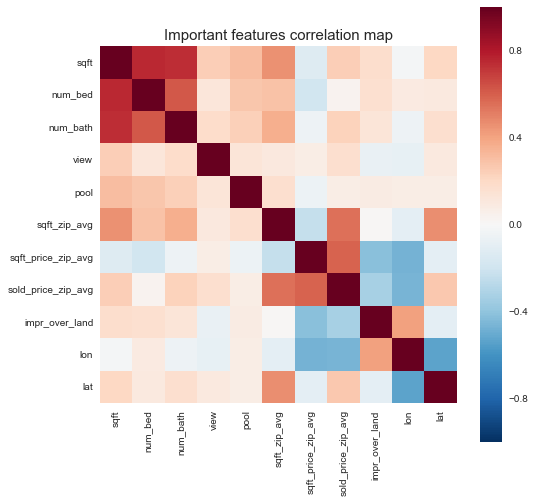

In [11]:
corr_features = list(features)
corr_features = pp.get_feature_list()
corrmat = df_last_year_valid[corr_features].corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important features correlation map", fontsize=15)
plt.show()